In [305]:
import pyod
import numpy as np
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from pyod.models.lof import LOF 
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import make_blobs
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from pyod.models.combination import maximization, average
from pyod.utils.utility import standardizer

np.random.seed(100)

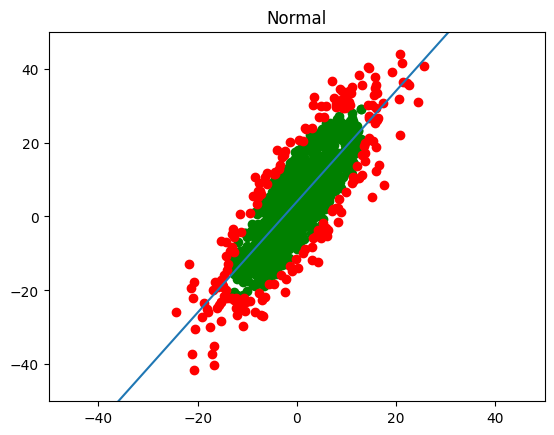

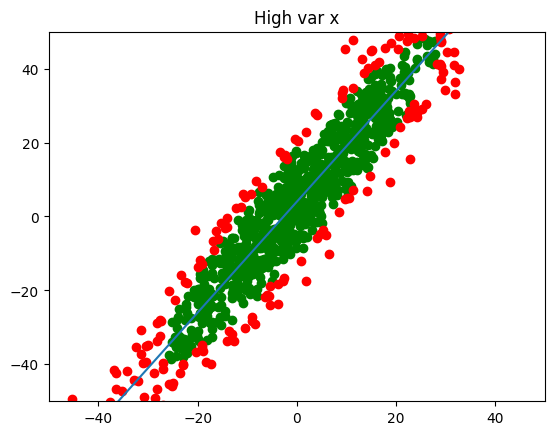

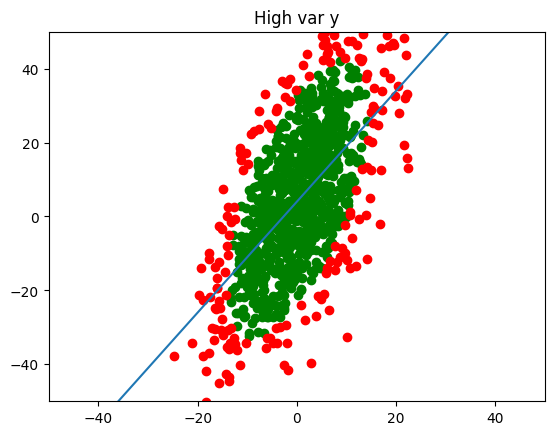

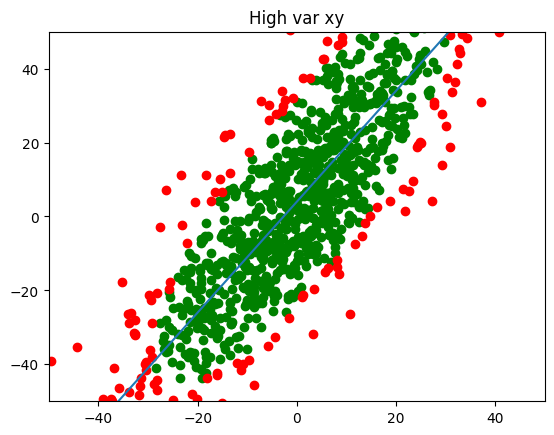

In [88]:
# Exercise 1
# 2D version

a = 1.5 
b = 4 

def random_points(x_stdev, noise_stdev, N=1000):
    x_positions = np.random.normal(loc=0, scale=x_stdev, size=N)
    noise = np.random.normal(0, noise_stdev, size=N)
    y_positions = a * x_positions + b + noise

    X = np.stack((x_positions, y_positions, np.ones(N)), axis=-1) 
    return X

def compute_leverages(X):
   z = np.matmul(X.T, X)
   w = np.linalg.solve(z, X.T)
   H = np.matmul(X, w)
   leverages = [H[i, i] for i in range(len(X))]
   return leverages

# def compute_leverages(X):
#    z = np.matmul(X.T, X)
#    z = np.linalg.inv(z)
#    H = np.matmul(X, np.matmul(z, X.T))
#    leverages = [H[i, i] for i in range(len(X))]
#    return leverages

def plot(points, title):
    plt.xlim(-50, 50)
    plt.ylim(-50, 50)
    leverage_scores = compute_leverages(points)
    expected_value = np.float64(2/1000)

    distances = np.abs(leverage_scores - expected_value)
    threshold = np.quantile(distances, 0.8)

    is_anomaly = distances > threshold
    anomalous = points[is_anomaly]
    non_anomalous = points[~is_anomaly]

    plt.title(title)
    plt.axline((-10, -10 *a +b), (10, 10 * a + b))
    plt.scatter(non_anomalous[:, 0], non_anomalous[:, 1], color="g")
    plt.scatter(anomalous[:, 0], anomalous[:, 1], color="r")
    plt.show()

normal_points = random_points(x_stdev=8, noise_stdev=8) 
high_var_x= random_points(x_stdev=16, noise_stdev=8) 
high_var_y= random_points(x_stdev=8, noise_stdev=16) 
high_var_xy= random_points(x_stdev=16, noise_stdev=16) 

plot(normal_points, "Normal")
plot(high_var_x, "High var x")
plot(high_var_y, "High var y")
plot(high_var_xy, "High var xy")

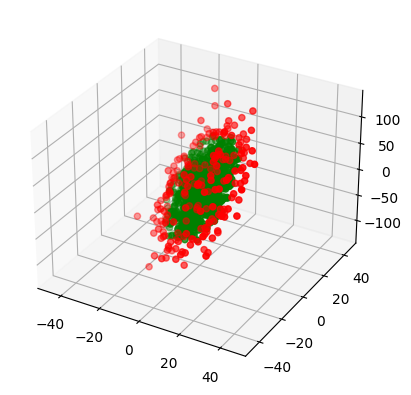

In [99]:
# Exercise 1
# 3D version
a = 1.5 
b =  4 
c = 2

def random_points(x1_stdev, x2_stdev, noise_stdev, N=1000):
    x1_positions = np.random.normal(loc=0, scale=x1_stdev, size=N)
    x2_positions = np.random.normal(loc=0, scale=x2_stdev, size=N)
    noise = np.random.normal(0, noise_stdev, size=N)

    y_positions = a * x1_positions + b*x2_positions + c + noise

    X = np.stack((x1_positions, x2_positions, y_positions, np.ones(N)), axis=-1) 
    return X

def plot(points):
    leverage_scores = compute_leverages(points)
    expected_value = np.float64(2/1000)

    distances = np.abs(leverage_scores - expected_value)
    threshold = np.quantile(distances, 0.8)

    is_anomaly = distances > threshold
    anomalous = points[is_anomaly]
    non_anomalous = points[~is_anomaly]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)


    ax.scatter(non_anomalous[:, 0], non_anomalous[:, 1], non_anomalous[:, 2], color="g")
    ax.scatter(anomalous[:, 0], anomalous[:, 1], anomalous[:, 2], color="r")
    plt.show()


normal_points = random_points(x1_stdev=8, x2_stdev=8, noise_stdev=16, N=1000) 
plot(normal_points)


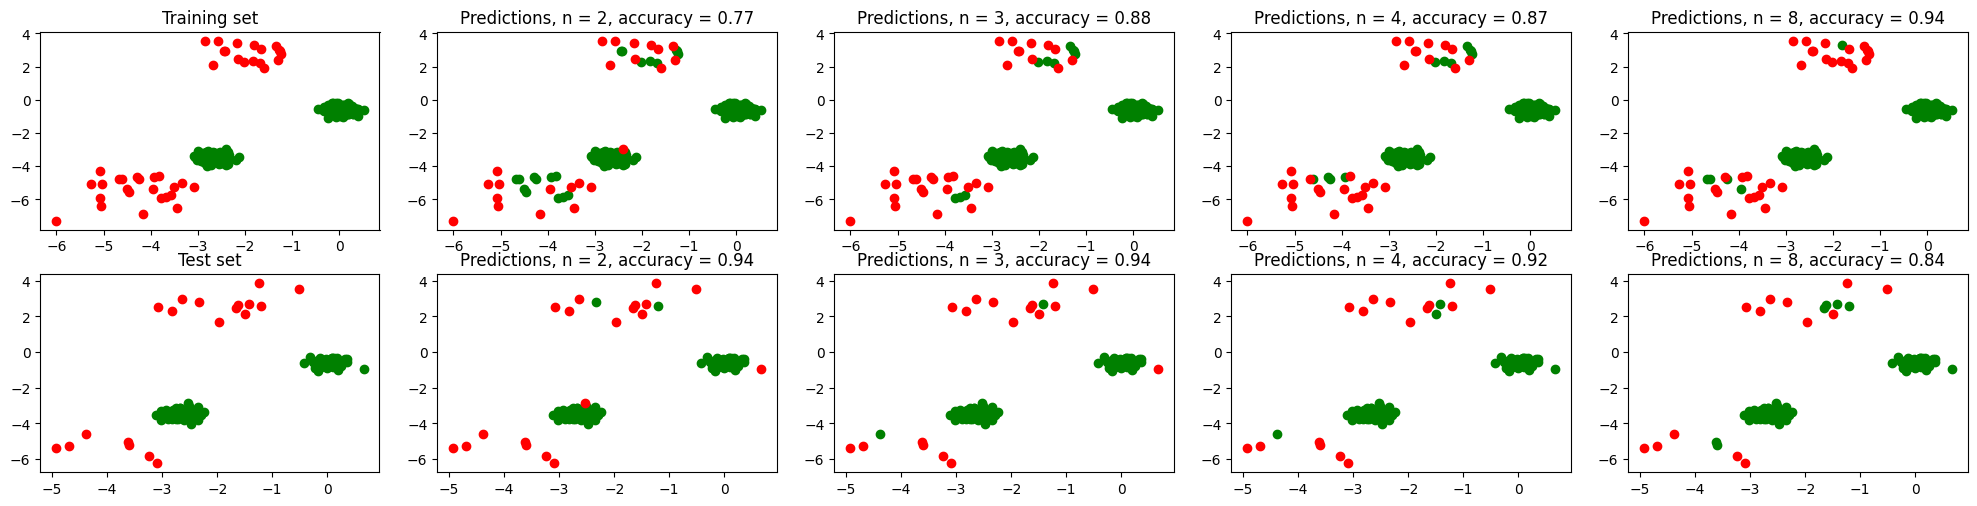

In [217]:
# Exercise 2

plt.rcParams['figure.figsize'] = [20, 5]

# Generating the dataset.
X_train, X_test, y_train, y_test = generate_data_clusters(n_train=400, n_test=200, n_clusters=2, n_features=2, contamination=0.1, random_state=1234)

fig, axs = plt.subplots(2, 5)
fig.tight_layout()

axs[0, 0].set_title("Training set")
axs[0, 0].scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], c="g")
axs[0, 0].scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], c="r")

axs[1, 0].set_title("Test set")
axs[1, 0].scatter(X_test[y_test==0][:, 0], X_test[y_test==0][:, 1], c="g")
axs[1, 0].scatter(X_test[y_test==1][:, 0], X_test[y_test==1][:, 1], c="r")

# Fit multiple models.
n_neighbors = [2, 3, 4, 8]
models = [KNN(contamination=0.1, n_neighbors=n) for n in n_neighbors]
for model in models:
    model.fit(X_train)

def try_model(model, X, y, ax):
    predictions = model.predict(X)

    ax.scatter(X[predictions==0][:, 0], X[predictions==0][:, 1], c="g")
    ax.scatter(X[predictions==1][:, 0], X[predictions==1][:, 1], c="r")

    return balanced_accuracy_score(y, predictions)

for i, (n, model) in enumerate(zip(n_neighbors, models)):
    accuracy = try_model(model, X_train, y_train,  axs[0, i+1])
    axs[0, i+1].set_title(f"Predictions, n = {n}, accuracy = {accuracy:.2f}")

for i, (n, model) in enumerate(zip(n_neighbors, models)):
    accuracy = try_model(model, X_test, y_test, axs[1, i+1])
    axs[1, i+1].set_title(f"Predictions, n = {n}, accuracy = {accuracy:.2f}")


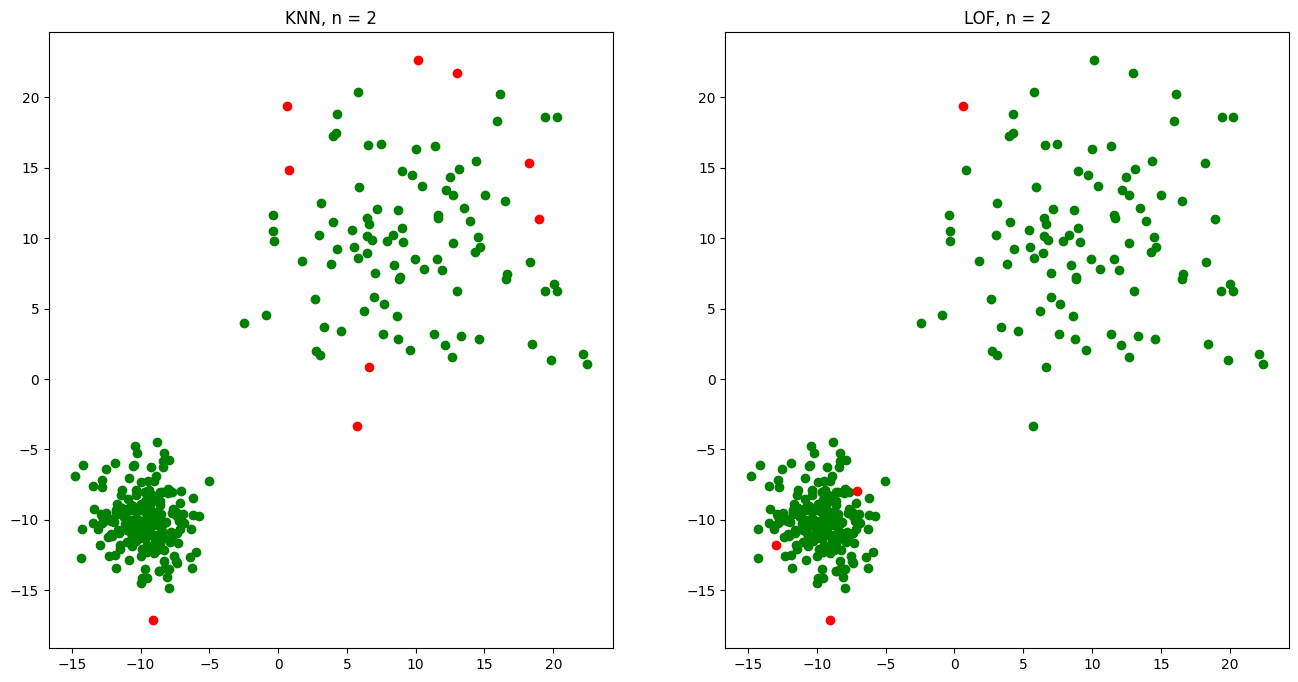

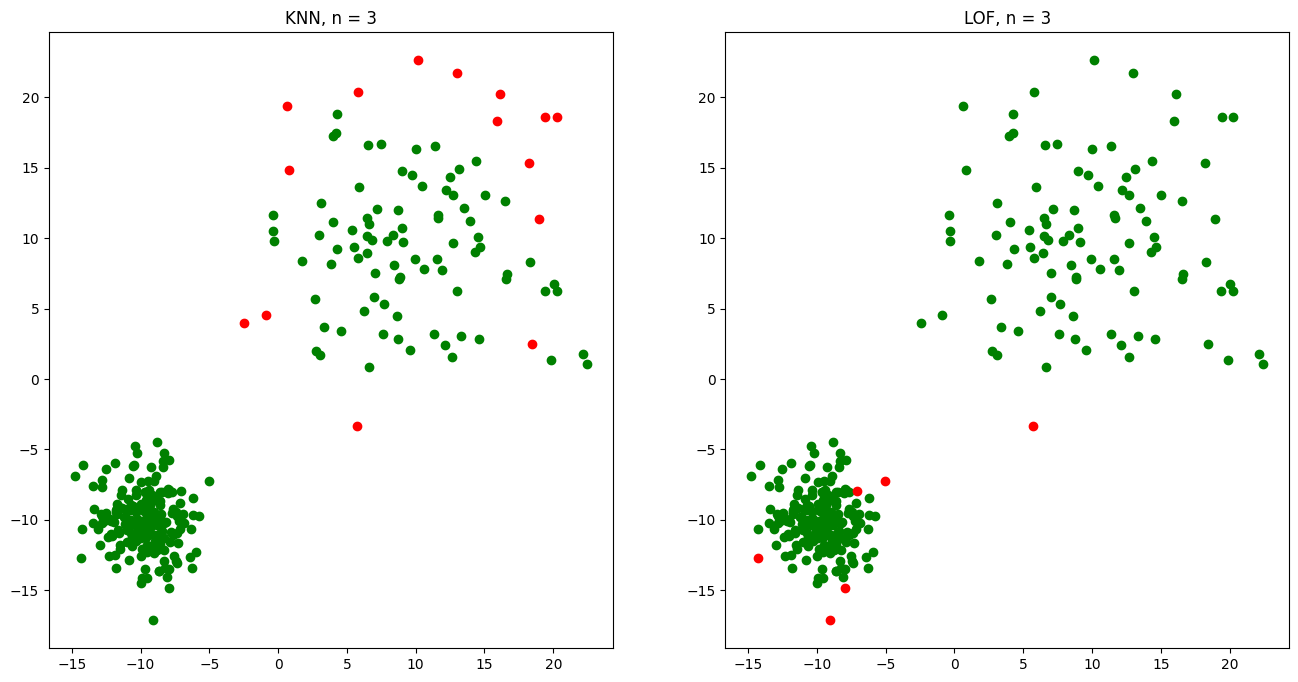

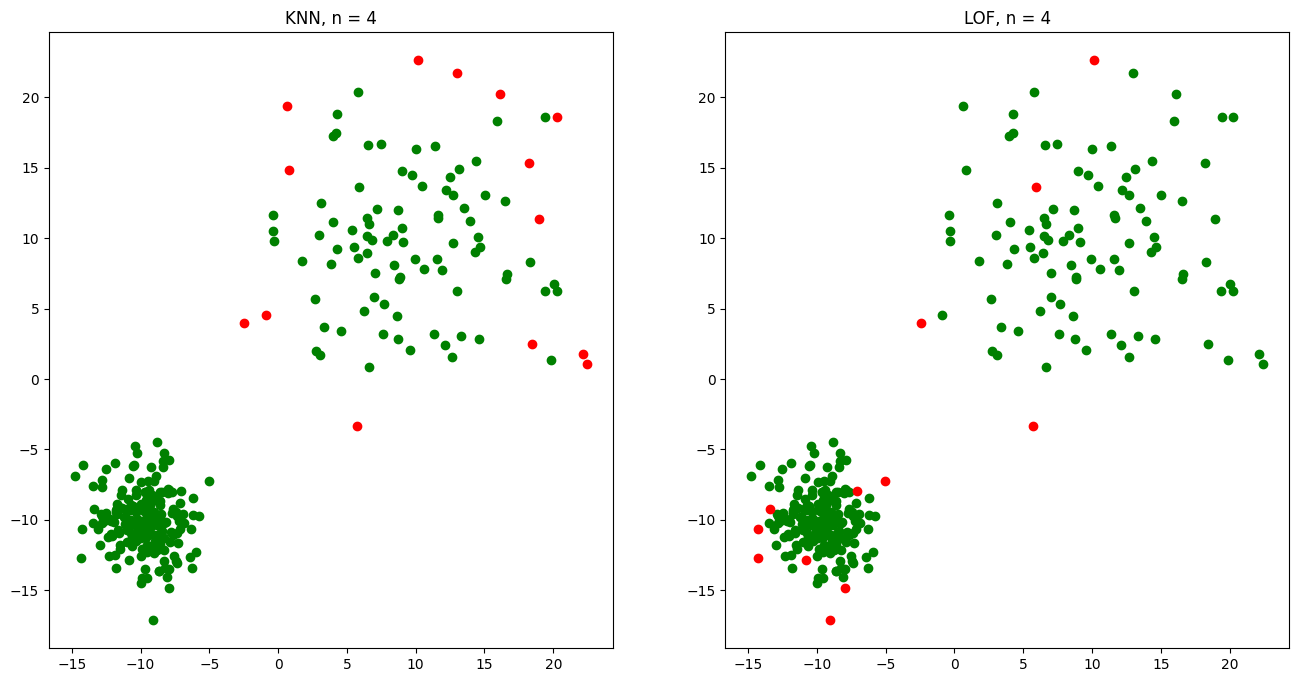

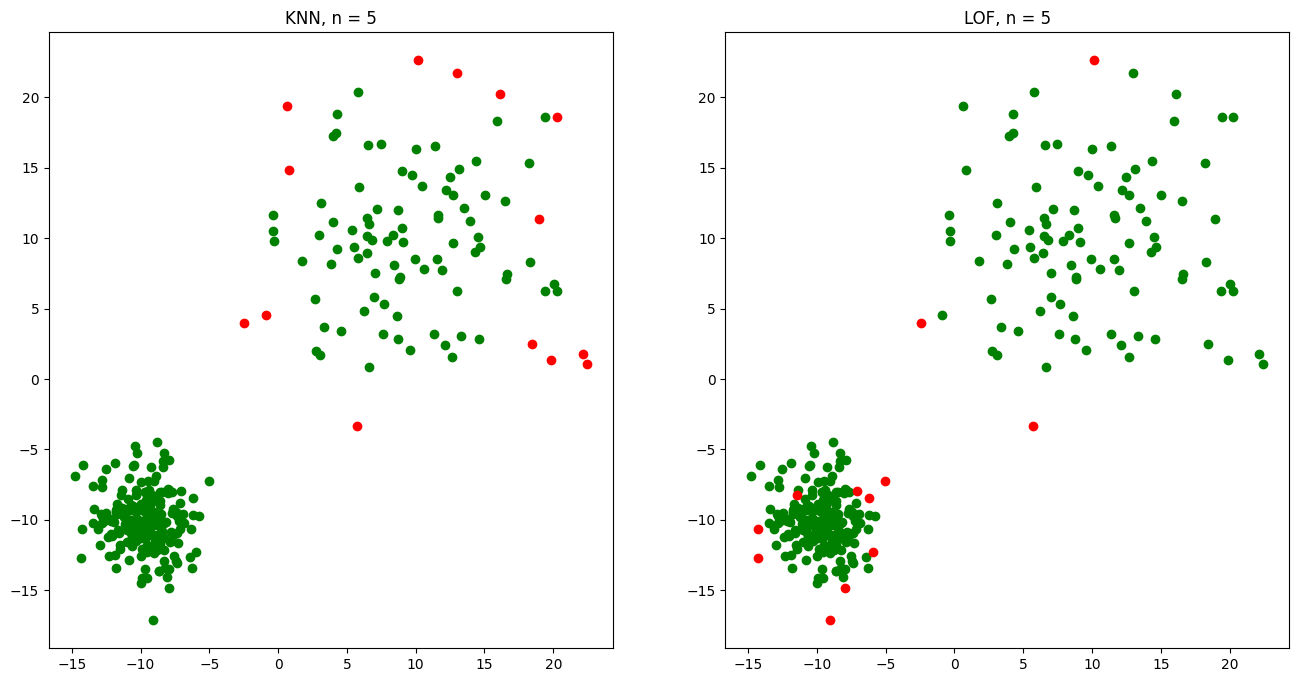

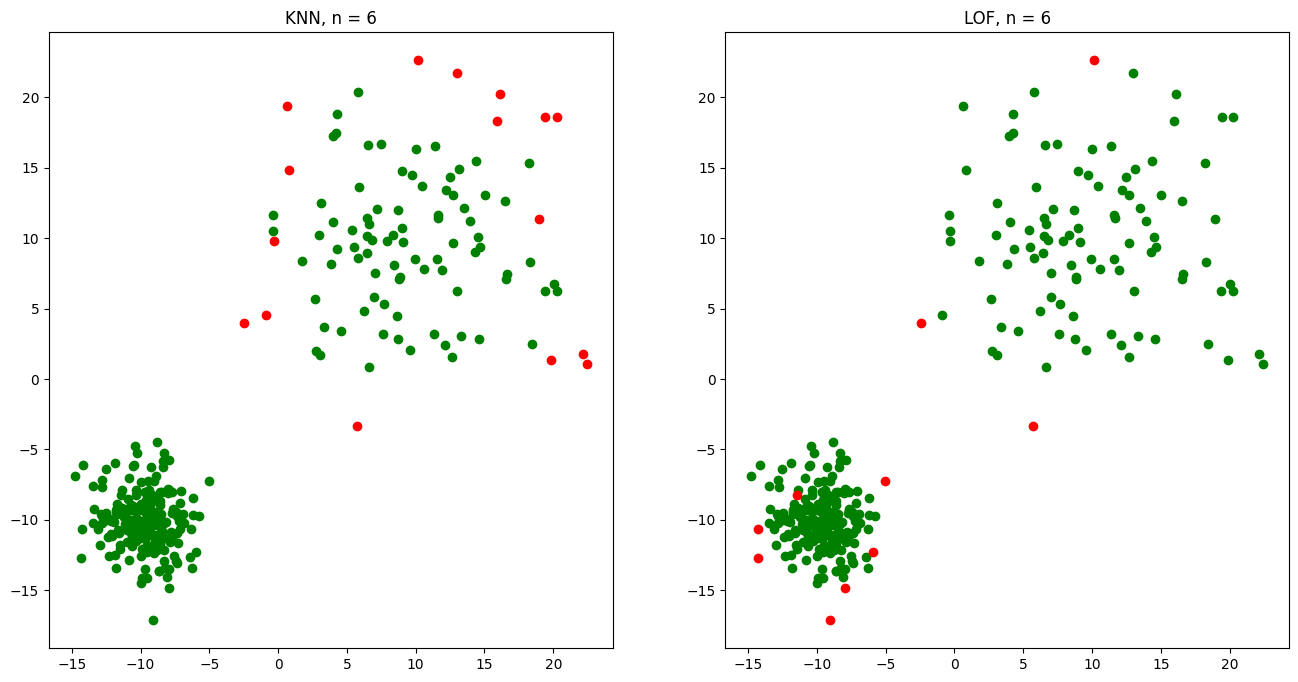

In [242]:
# Exercise 3
plt.rcParams['figure.figsize'] = [16, 8]

# Generating the dataset.
X, _ = make_blobs([200, 100], n_features=2, centers=[[-10, -10], [10, 10]], cluster_std=[2, 6], random_state=1234)

n_neighbors = [2, 3, 4, 5, 6]

for (i, n) in enumerate(n_neighbors):
    fig, axs = plt.subplots(1, 2)

    knn = KNN(contamination=0.07, n_neighbors=n)
    knn.fit(X)

    lof = LOF(contamination=0.07, n_neighbors=n)
    lof.fit(X)

    predictions_knn = knn.predict(X)
    predictions_lof = lof.predict(X)


    axs[0].set_title(f"KNN, n = {n}")
    axs[0].scatter(X[predictions_knn == 0][:, 0], X[predictions_knn == 0][:, 1], c="g")
    axs[0].scatter(X[predictions_knn == 1][:, 0], X[predictions_knn == 1][:, 1], c="r")

    axs[1].set_title(f"LOF, n = {n}")
    axs[1].scatter(X[predictions_lof == 0][:, 0], X[predictions_lof == 0][:, 1], c="g")
    axs[1].scatter(X[predictions_lof == 1][:, 0], X[predictions_lof == 1][:, 1], c="r")
    plt.show()

In [319]:
# Exercise 4

# Loading the data.
data = loadmat("cardio.mat")
X, y = data["X"], data["y"].squeeze()


# Train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Compute the contamination rate on the train set to prevent information leaking.
contamination_rate = np.sum(y_train)/len(y_train)

# Creating a bunch of LOF models.
num_models = 10
n_neighbors = np.linspace(30, 120, num_models).astype(int)
print(f"Creating ensemble:")

# Get a list of models. For each model, keep the list of scores on the training set and test set.
models = []
train_scores = [] 
test_scores = []

for n in n_neighbors:
    # Contamination rate does not matter here, we only care about the decision function.
    model = LOF(n_neighbors=n)
    model.fit(X_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_accuracy = balanced_accuracy_score(y_train, train_predictions)
    test_accuracy = balanced_accuracy_score(y_test, test_predictions)

    train_scores.append(model.decision_function(X_train))
    test_scores.append(model.decision_function(X_test))
    print(f"Balanced of LOF(n={n}): train_set: {train_accuracy}, test_set: {test_accuracy}", )


# Train scores and test scores are matrices of shape: (n, num_samples)
# We need a matrix of scores with a shape of (num_samples, n)
train_scores = np.array(train_scores).T
test_scores = np.array(test_scores).T

# Normalize the scores. This is probably done so that all models have equal contribution. 
train_scores = standardizer(train_scores)
test_scores = standardizer(test_scores)

# Get the final scores using two strategies: maximization or averaging.
train_scores_maximization = maximization(train_scores)
train_scores_averaging = average(train_scores)

test_scores_maximization = maximization(test_scores)
test_scores_averaging = average(test_scores)

# Find the threshold for both strategies.
threshold_maximization = np.quantile(train_scores_maximization, 1-contamination_rate)
threshold_averaging = np.quantile(train_scores_averaging, 1-contamination_rate)

# Make the predictions using the ensemble

# Maximization strategy.
predictions_train_maximization = train_scores_maximization > threshold_maximization 
predictions_test_maximization = test_scores_maximization > threshold_maximization 
accuracy_train_maximization = balanced_accuracy_score(y_train, predictions_train_maximization)
accuracy_test_maximization = balanced_accuracy_score(y_test, predictions_test_maximization)
print(f"MAXIMIZATION STRAGEGY: train accuracy: {accuracy_train_maximization}, test accuracy: {accuracy_test_maximization}")

# Averaging strategy.
predictions_train_averaging = train_scores_averaging > threshold_averaging
predictions_test_averaging = test_scores_averaging > threshold_averaging
accuracy_train_averaging = balanced_accuracy_score(y_train, predictions_train_averaging)
accuracy_test_averaging = balanced_accuracy_score(y_test, predictions_test_averaging)
print(f"AVERAGING STRAGEGY: train accuracy: {accuracy_train_averaging}, test accuracy: {accuracy_test_averaging}")

Creating ensemble:
Balanced of LOF(n=30): train_set: 0.5366578668385058, test_set: 0.5054896142433235
Balanced of LOF(n=40): train_set: 0.5545398798511652, test_set: 0.504005934718101
Balanced of LOF(n=50): train_set: 0.5606304695782318, test_set: 0.5025222551928784
Balanced of LOF(n=60): train_set: 0.567479784646725, test_set: 0.5025222551928784
Balanced of LOF(n=70): train_set: 0.5712838048516847, test_set: 0.5343719090009891
Balanced of LOF(n=80): train_set: 0.5868792483422371, test_set: 0.5554896142433234
Balanced of LOF(n=90): train_set: 0.5914419938886233, test_set: 0.5751236399604353
Balanced of LOF(n=100): train_set: 0.6089446442305694, test_set: 0.5962413452027695
Balanced of LOF(n=110): train_set: 0.6237813623796953, test_set: 0.5992087042532146
Balanced of LOF(n=120): train_set: 0.6355727856652877, test_set: 0.6006923837784371
MAXIMIZATION STRAGEGY: train accuracy: 0.5929698380693038, test accuracy: 0.6054896142433235
AVERAGING STRAGEGY: train accuracy: 0.5815577774544245, t